In [1]:
import pandas as pd
import numpy as np
import math
import os
import tqdm
import string

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import glob
import os
import gc

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from scipy.stats import entropy
from math import log, e

from sklearn.metrics import accuracy_score

from dateutil.parser import parse

import re

import seaborn as sns

In [2]:
def rmsle(y_pred, y_true): 
    return np.sqrt(np.square(np.log((y_pred + 1)/(y_true + 1))).mean())

In [3]:
def entropy2(labels, base=2):
    """ Computes entropy of label distribution. """

    n_labels = len(labels)

    if n_labels <= 1:
        return 0

    value,counts = np.unique(labels, return_counts=True)
    probs = counts / n_labels
    n_classes = np.count_nonzero(probs)

    if n_classes <= 1:
        return 0

    ent = 0.

    # Compute entropy
    base = e if base is None else base
    for i in probs:
        ent -= i * log(i, base)

    return ent

In [4]:
path_to_ft = r'F:\data\dmia\df.ft'

In [121]:
train = pd.read_csv('../data/train.csv', keep_default_na=False, na_values=[',,'])
test = pd.read_csv('../data/Xtest.csv', keep_default_na=False, na_values=[',,'])

In [122]:
train.drop(train[train['Password'].str.len() == 0].index, inplace=True)

# Сливаем данные и генерируем фичи

In [6]:
test['Times'] = 0

In [7]:
test.drop(['Id'], inplace=True, axis = 1)

In [8]:
df = pd.concat([train, test], axis=0)

In [9]:
df['times_log'] = np.log1p(df['Times'])

In [10]:
df['class'] = -1
df['class_log'] = -1

In [11]:
df.head()

,Password,Times,times_log,class,class_log
0,631XniVx2lS5I,2,1.098612,-1,-1
1,LEGIT747,1,0.693147,-1,-1
2,742364es,1,0.693147,-1,-1
3,3846696477,1,0.693147,-1,-1
4,laurahop,2,1.098612,-1,-1


### Фича - длина пароля

In [12]:
df['len'] = df['Password'].str.len()

In [13]:
df.head()

,Password,Times,times_log,class,class_log,len
0,631XniVx2lS5I,2,1.098612,-1,-1,13
1,LEGIT747,1,0.693147,-1,-1,8
2,742364es,1,0.693147,-1,-1,8
3,3846696477,1,0.693147,-1,-1,10
4,laurahop,2,1.098612,-1,-1,8


### Фича - является ли пароль словом и, если да, то насколько популярным

In [1]:
#https://raw.githubusercontent.com/jonmeow/puzzling/master/google-books-common-words.txt

In [2]:
#https://raw.githubusercontent.com/matijhs/solid-mapreduce-journey/9e0574f3164970e72e57732dfb46be8c68c96f0b/persons-counter/first-names1.txt

In [96]:
words = pd.read_csv('google-books-common-words.txt', keep_default_na=False, na_values=[',,'], delimiter = '\t', header = None)

In [97]:
words.rename(columns={ words.columns[0]: "word" }, inplace = True)

In [98]:
words.drop(words.columns[1], axis = 1, inplace=True)

In [99]:
words['word'] = words['word'].str.lower()

In [100]:
words.drop_duplicates(subset ="word", keep = False, inplace = True)

In [101]:
n = len(words)

In [102]:
words['freq'] = np.log(n/(words.index.values+1) + 1)

In [103]:
words.sort_values(by = 'freq')

,word,freq
97564,westergaard,0.693147
97563,losey,0.693152
97562,xxl,0.693157
97561,evang,0.693163
97560,oilmen,0.693168
...,...,...
4,in,9.878887
3,to,10.102021
2,and,10.389693
1,of,10.795147


In [22]:
Password_lower = df['Password'].str.lower()

In [23]:
df.insert(1, 'Password_lower', Password_lower)

In [24]:
df.head()

,Password,Password_lower,Times,times_log,class,class_log,len
0,631XniVx2lS5I,631xnivx2ls5i,2,1.098612,-1,-1,13
1,LEGIT747,legit747,1,0.693147,-1,-1,8
2,742364es,742364es,1,0.693147,-1,-1,8
3,3846696477,3846696477,1,0.693147,-1,-1,10
4,laurahop,laurahop,2,1.098612,-1,-1,8


In [104]:
str_only = df['Password_lower'].str.replace(pat="[^a-z]", repl="")

In [105]:
df.head()

,Password,Password_lower,Times,times_log,class,class_log,len,freq,isword,isname,contains_name,isdigit,isalpha,islower,isupper,istitle,isalnum,contains_punct,contains_digit,contains_lower_letters,contains_upper_letters,entropy,unique_symbols,is_palindrome,is_symmetric,end_with_digits,sbs4,sbs5,sbs6,sbs7,sbs8,sbs9,sbs10,num_classes,is_date,rank
0,631XniVx2lS5I,631xnivx2ls5i,2,1.098612,1,1,13,0.0,False,False,False,False,False,False,False,False,True,False,True,True,True,3.700440,13,False,False,False,False,False,False,False,False,False,False,3,False,36.900879
1,LEGIT747,legit747,1,0.693147,0,0,8,0.0,False,False,True,False,False,False,True,False,True,False,True,False,True,2.750000,7,False,False,False,False,False,False,False,False,False,False,2,False,22.500000
2,742364es,742364es,1,0.693147,0,0,8,0.0,False,False,False,False,False,True,False,False,True,False,True,True,False,2.750000,7,False,False,False,False,False,False,False,False,False,False,2,False,23.000000
3,3846696477,3846696477,1,0.693147,0,0,10,0.0,False,False,False,True,False,False,False,False,True,False,True,False,False,2.446439,6,False,False,False,False,False,False,False,False,False,False,1,False,17.392879
4,laurahop,laurahop,2,1.098612,1,1,8,0.0,False,False,True,False,True,True,False,False,True,False,False,True,False,2.750000,7,False,False,False,False,False,False,False,False,False,False,1,False,19.500000


In [110]:
df.insert(2, 'str_only', str_only)

In [111]:
df.head()

,Password,Password_lower,str_only,Times,times_log,class,class_log,len,freq,isword,isname,contains_name,isdigit,isalpha,islower,isupper,istitle,isalnum,contains_punct,contains_digit,contains_lower_letters,contains_upper_letters,entropy,unique_symbols,is_palindrome,is_symmetric,end_with_digits,sbs4,sbs5,sbs6,sbs7,sbs8,sbs9,sbs10,num_classes,is_date,rank
0,631XniVx2lS5I,631xnivx2ls5i,xnivxlsi,2,1.098612,1,1,13,0.0,False,False,False,False,False,False,False,False,True,False,True,True,True,3.700440,13,False,False,False,False,False,False,False,False,False,False,3,False,36.900879
1,LEGIT747,legit747,legit,1,0.693147,0,0,8,0.0,False,False,True,False,False,False,True,False,True,False,True,False,True,2.750000,7,False,False,False,False,False,False,False,False,False,False,2,False,22.500000
2,742364es,742364es,es,1,0.693147,0,0,8,0.0,False,False,False,False,False,True,False,False,True,False,True,True,False,2.750000,7,False,False,False,False,False,False,False,False,False,False,2,False,23.000000
3,3846696477,3846696477,,1,0.693147,0,0,10,0.0,False,False,False,True,False,False,False,False,True,False,True,False,False,2.446439,6,False,False,False,False,False,False,False,False,False,False,1,False,17.392879
4,laurahop,laurahop,laurahop,2,1.098612,1,1,8,0.0,False,False,True,False,True,True,False,False,True,False,False,True,False,2.750000,7,False,False,False,False,False,False,False,False,False,False,1,False,19.500000


In [113]:
words.rename(columns={'freq': 'contains_word'}, inplace=True)

In [114]:
words.head()

,word,contains_word
0,the,11.488284
1,of,10.795147
2,and,10.389693
3,to,10.102021
4,in,9.878887


In [116]:
words['contains_word'] = True

In [117]:
words.head()

,word,contains_word
0,the,True
1,of,True
2,and,True
3,to,True
4,in,True


In [118]:
df = pd.merge(df, words, left_on='str_only', right_on ='word', how='left')

In [119]:
df.head()

,Password,Password_lower,str_only,Times,times_log,class,class_log,len,freq,isword,isname,contains_name,isdigit,isalpha,islower,isupper,istitle,isalnum,contains_punct,contains_digit,contains_lower_letters,contains_upper_letters,entropy,unique_symbols,is_palindrome,is_symmetric,end_with_digits,sbs4,sbs5,sbs6,sbs7,sbs8,sbs9,sbs10,num_classes,is_date,rank,word,contains_word
0,631XniVx2lS5I,631xnivx2ls5i,xnivxlsi,2,1.098612,1,1,13,0.0,False,False,False,False,False,False,False,False,True,False,True,True,True,3.700440,13,False,False,False,False,False,False,False,False,False,False,3,False,36.900879,NaN,NaN
1,LEGIT747,legit747,legit,1,0.693147,0,0,8,0.0,False,False,True,False,False,False,True,False,True,False,True,False,True,2.750000,7,False,False,False,False,False,False,False,False,False,False,2,False,22.500000,legit,True
2,742364es,742364es,es,1,0.693147,0,0,8,0.0,False,False,False,False,False,True,False,False,True,False,True,True,False,2.750000,7,False,False,False,False,False,False,False,False,False,False,2,False,23.000000,es,True
3,3846696477,3846696477,,1,0.693147,0,0,10,0.0,False,False,False,True,False,False,False,False,True,False,True,False,False,2.446439,6,False,False,False,False,False,False,False,False,False,False,1,False,17.392879,NaN,NaN
4,laurahop,laurahop,laurahop,2,1.098612,1,1,8,0.0,False,False,True,False,True,True,False,False,True,False,False,True,False,2.750000,7,False,False,False,False,False,False,False,False,False,False,1,False,19.500000,NaN,NaN


In [126]:
df.fillna(False, inplace=True)

In [25]:
df = pd.merge(df, words, left_on='Password_lower', right_on ='word', how='left')

In [26]:
df.fillna(0, inplace=True)

In [127]:
df.head()

,Password,Password_lower,str_only,Times,times_log,class,class_log,len,freq,isword,isname,contains_name,isdigit,isalpha,islower,isupper,istitle,isalnum,contains_punct,contains_digit,contains_lower_letters,contains_upper_letters,entropy,unique_symbols,is_palindrome,is_symmetric,end_with_digits,sbs4,sbs5,sbs6,sbs7,sbs8,sbs9,sbs10,num_classes,is_date,rank,contains_word
0,631XniVx2lS5I,631xnivx2ls5i,xnivxlsi,2,1.098612,1,1,13,0.0,False,False,False,False,False,False,False,False,True,False,True,True,True,3.700440,13,False,False,False,False,False,False,False,False,False,False,3,False,36.900879,False
1,LEGIT747,legit747,legit,1,0.693147,0,0,8,0.0,False,False,True,False,False,False,True,False,True,False,True,False,True,2.750000,7,False,False,False,False,False,False,False,False,False,False,2,False,22.500000,True
2,742364es,742364es,es,1,0.693147,0,0,8,0.0,False,False,False,False,False,True,False,False,True,False,True,True,False,2.750000,7,False,False,False,False,False,False,False,False,False,False,2,False,23.000000,True
3,3846696477,3846696477,,1,0.693147,0,0,10,0.0,False,False,False,True,False,False,False,False,True,False,True,False,False,2.446439,6,False,False,False,False,False,False,False,False,False,False,1,False,17.392879,False
4,laurahop,laurahop,laurahop,2,1.098612,1,1,8,0.0,False,False,True,False,True,True,False,False,True,False,False,True,False,2.750000,7,False,False,False,False,False,False,False,False,False,False,1,False,19.500000,False


In [123]:
len(df) == len(train) + len(test)

True

In [124]:
df.drop('word', axis = 1, inplace = True)

In [30]:
df['isword'] = (df['freq'] > 0)

In [125]:
df.head()

,Password,Password_lower,str_only,Times,times_log,class,class_log,len,freq,isword,isname,contains_name,isdigit,isalpha,islower,isupper,istitle,isalnum,contains_punct,contains_digit,contains_lower_letters,contains_upper_letters,entropy,unique_symbols,is_palindrome,is_symmetric,end_with_digits,sbs4,sbs5,sbs6,sbs7,sbs8,sbs9,sbs10,num_classes,is_date,rank,contains_word
0,631XniVx2lS5I,631xnivx2ls5i,xnivxlsi,2,1.098612,1,1,13,0.0,False,False,False,False,False,False,False,False,True,False,True,True,True,3.700440,13,False,False,False,False,False,False,False,False,False,False,3,False,36.900879,NaN
1,LEGIT747,legit747,legit,1,0.693147,0,0,8,0.0,False,False,True,False,False,False,True,False,True,False,True,False,True,2.750000,7,False,False,False,False,False,False,False,False,False,False,2,False,22.500000,True
2,742364es,742364es,es,1,0.693147,0,0,8,0.0,False,False,False,False,False,True,False,False,True,False,True,True,False,2.750000,7,False,False,False,False,False,False,False,False,False,False,2,False,23.000000,True
3,3846696477,3846696477,,1,0.693147,0,0,10,0.0,False,False,False,True,False,False,False,False,True,False,True,False,False,2.446439,6,False,False,False,False,False,False,False,False,False,False,1,False,17.392879,NaN
4,laurahop,laurahop,laurahop,2,1.098612,1,1,8,0.0,False,False,True,False,True,True,False,False,True,False,False,True,False,2.750000,7,False,False,False,False,False,False,False,False,False,False,1,False,19.500000,NaN


In [32]:
names = pd.read_csv('../data/names.txt', keep_default_na=False, na_values=[',,'], header = None)

In [33]:
names.head()

,0
0,aaren
1,aarika
2,abagael
3,abagail
4,abbe


In [34]:
names.rename(columns={ names.columns[0]: "name" }, inplace = True)

In [35]:
names.head()

,name
0,aaren
1,aarika
2,abagael
3,abagail
4,abbe


In [36]:
names.drop_duplicates(subset ="name", keep = False, inplace = True)

In [37]:
len(names)

6201

In [38]:
names['isname'] = True

In [39]:
df = pd.merge(df, names, left_on='Password_lower', right_on = 'name', how='left')

In [40]:
df.fillna(False, inplace=True)

In [41]:
df.head()

,Password,Password_lower,Times,times_log,class,class_log,len,freq,isword,name,isname
0,631XniVx2lS5I,631xnivx2ls5i,2,1.098612,-1,-1,13,0.0,False,False,False
1,LEGIT747,legit747,1,0.693147,-1,-1,8,0.0,False,False,False
2,742364es,742364es,1,0.693147,-1,-1,8,0.0,False,False,False
3,3846696477,3846696477,1,0.693147,-1,-1,10,0.0,False,False,False
4,laurahop,laurahop,2,1.098612,-1,-1,8,0.0,False,False,False


In [42]:
len(df) == len(train) + len(test)

True

In [43]:
df.drop('name', axis = 1, inplace = True)

In [44]:
df['isname'] = df['isname']

In [45]:
all_names_regex = '|'.join(names['name'].values)

In [46]:
df['contains_name'] = False

In [47]:
df['contains_name'] = df['Password_lower'].str.contains(pat = all_names_regex, regex = True, case = True)
df.head()

,Password,Password_lower,Times,times_log,class,class_log,len,freq,isword,isname,contains_name
0,631XniVx2lS5I,631xnivx2ls5i,2,1.098612,-1,-1,13,0.0,False,False,False
1,LEGIT747,legit747,1,0.693147,-1,-1,8,0.0,False,False,True
2,742364es,742364es,1,0.693147,-1,-1,8,0.0,False,False,False
3,3846696477,3846696477,1,0.693147,-1,-1,10,0.0,False,False,False
4,laurahop,laurahop,2,1.098612,-1,-1,8,0.0,False,False,True


In [48]:
df.head()

,Password,Password_lower,Times,times_log,class,class_log,len,freq,isword,isname,contains_name
0,631XniVx2lS5I,631xnivx2ls5i,2,1.098612,-1,-1,13,0.0,False,False,False
1,LEGIT747,legit747,1,0.693147,-1,-1,8,0.0,False,False,True
2,742364es,742364es,1,0.693147,-1,-1,8,0.0,False,False,False
3,3846696477,3846696477,1,0.693147,-1,-1,10,0.0,False,False,False
4,laurahop,laurahop,2,1.098612,-1,-1,8,0.0,False,False,True


In [260]:
# df.to_feather(path_to_ft)
# df = pd.read_feather(path_to_ft)

### Дискретизируем Times

In [353]:
df['class'] = -1
df['class_log'] = -1

In [354]:
bins=[1,2,3,4,5,7,10,15,25,50,56000]
# bins=[1,2,10,56000]
# bins=[1,2,56000]

In [355]:
labels = list(range(len(bins) - 1))

In [356]:
# X = df[df['Times'] > 0].copy()

In [357]:
df.loc[df['Times'] > 0, 'class'] = pd.cut(x=df[df['Times'] > 0]['Times'], bins=bins, labels = labels, right = False)

### Посмотрим размеры соответствующих классов(классы получились мягко говоря не сбалансированными)

In [358]:
class_sizes = df[df['Times'] > 0].groupby(['class']).size()
class_sizes

class
0    3547155
1     309205
2      96462
3      47704
4      46530
5      32437
6      24879
7      20697
8      16052
9      10374
dtype: int64

#### Вычислим среднее для каждого класса

In [359]:
means = df[df['Times'] > 0].groupby(['class'])['Times'].agg(['mean'])
means

,mean
class,
0,1.000000
1,2.000000
2,3.000000
3,4.000000
4,5.400322
5,7.833523
6,11.686844
7,18.766729
8,34.149576


In [360]:
# https://qanalysis.blogspot.com/2015/11/python-pandas-groupby-agg-percentiles.html?m=1
# https://stackoverflow.com/questions/17578115/pass-percentiles-to-pandas-agg-function
# quants = df[df['Times'] > 0].groupby(['class'])['Times'].describe(percentiles=[.75, .95])
# quants

# quants.iloc[:, 4]

# means['mean'] = quants.iloc[:, 4].values

#### Проверим метрику rlse на известных данных - возьмем классы из обучающей выборки и по среднему предскажем Times

In [361]:
times_preds = means.loc[df[df['Times'] > 0]['class'].values, 'mean'].values

In [362]:
y_true = df[df['Times'] > 0]['Times']

In [363]:
rmsle(times_preds, y_true.values)

0.046926415144961486

In [320]:
# s = class_sizes.sum()
# probs = class_sizes / s
# probs

# y_pred_classes = np.random.choice(class_sizes.index.values, size = len(df[df['Times'] > 0]), p = probs.values)

# len(y_pred_classes)

# times_preds = means.loc[y_pred_classes, 'mean'].values

# rmsle(times_preds, y_true.values)

### То же самое для times_log

In [364]:
bins=[np.log1p(1),np.log1p(2),np.log1p(3),np.log1p(4),np.log1p(5),np.log1p(7),np.log1p(10),np.log1p(20),np.log1p(30),np.log1p(50),np.log1p(56000)]
labels = list(range(len(bins) - 1))
df.loc[df['Times'] > 0, 'class_log'] = pd.cut(x=df[df['Times'] > 0]['times_log'], bins=bins, labels = labels, right = False)

In [365]:
df[df['Times'] > 0].groupby(['class_log']).size()

class_log
0    3547155
1     309205
2      96462
3      47704
4      46530
5      32437
6      37466
7      13494
8      10668
9      10374
dtype: int64

In [68]:
means_log = df[df['Times'] > 0].groupby(['class_log'])['times_log'].agg(['mean'])
means_log

,mean
class_log,
0,0.693147
1,1.098612
2,1.386294
3,1.609438
4,1.853469
5,2.174463
6,2.649034
7,3.206074
8,3.648541


In [367]:
times_log_preds = means_log.loc[df[df['Times'] > 0]['class_log'].values, 'mean'].values

In [368]:
times_preds = np.exp(times_log_preds) - 1

In [369]:
y_true = df[df['Times'] > 0]['Times']

In [370]:
rmsle(times_preds, y_true.values)

0.04277328456614242

In [329]:
# df.to_feather(path_to_ft)
# df = pd.read_feather(path_to_ft)

### Дальше генерим фичи понятные из их названий

In [330]:
df['isdigit'] = df['Password'].str.isdigit()
df.head()

,Password,Password_lower,Times,times_log,class,class_log,len,freq,isword,isname,contains_name,isdigit
0,631XniVx2lS5I,631xnivx2ls5i,2,1.098612,-1,-1,13,0.0,False,False,False,False
1,LEGIT747,legit747,1,0.693147,-1,-1,8,0.0,False,False,True,False
2,742364es,742364es,1,0.693147,-1,-1,8,0.0,False,False,False,False
3,3846696477,3846696477,1,0.693147,-1,-1,10,0.0,False,False,False,True
4,laurahop,laurahop,2,1.098612,-1,-1,8,0.0,False,False,True,False


In [331]:
df['isalpha'] = df['Password'].str.isalpha()
df.head()

,Password,Password_lower,Times,times_log,class,class_log,len,freq,isword,isname,contains_name,isdigit,isalpha
0,631XniVx2lS5I,631xnivx2ls5i,2,1.098612,-1,-1,13,0.0,False,False,False,False,False
1,LEGIT747,legit747,1,0.693147,-1,-1,8,0.0,False,False,True,False,False
2,742364es,742364es,1,0.693147,-1,-1,8,0.0,False,False,False,False,False
3,3846696477,3846696477,1,0.693147,-1,-1,10,0.0,False,False,False,True,False
4,laurahop,laurahop,2,1.098612,-1,-1,8,0.0,False,False,True,False,True


In [332]:
df['islower'] = df['Password'].str.islower()
df.head()

,Password,Password_lower,Times,times_log,class,class_log,len,freq,isword,isname,contains_name,isdigit,isalpha,islower
0,631XniVx2lS5I,631xnivx2ls5i,2,1.098612,-1,-1,13,0.0,False,False,False,False,False,False
1,LEGIT747,legit747,1,0.693147,-1,-1,8,0.0,False,False,True,False,False,False
2,742364es,742364es,1,0.693147,-1,-1,8,0.0,False,False,False,False,False,True
3,3846696477,3846696477,1,0.693147,-1,-1,10,0.0,False,False,False,True,False,False
4,laurahop,laurahop,2,1.098612,-1,-1,8,0.0,False,False,True,False,True,True


In [333]:
df['isupper'] = df['Password'].str.isupper()
df.head()

,Password,Password_lower,Times,times_log,class,class_log,len,freq,isword,isname,contains_name,isdigit,isalpha,islower,isupper
0,631XniVx2lS5I,631xnivx2ls5i,2,1.098612,-1,-1,13,0.0,False,False,False,False,False,False,False
1,LEGIT747,legit747,1,0.693147,-1,-1,8,0.0,False,False,True,False,False,False,True
2,742364es,742364es,1,0.693147,-1,-1,8,0.0,False,False,False,False,False,True,False
3,3846696477,3846696477,1,0.693147,-1,-1,10,0.0,False,False,False,True,False,False,False
4,laurahop,laurahop,2,1.098612,-1,-1,8,0.0,False,False,True,False,True,True,False


In [334]:
df['istitle'] = df['Password'].str.istitle()
df.head()

,Password,Password_lower,Times,times_log,class,class_log,len,freq,isword,isname,contains_name,isdigit,isalpha,islower,isupper,istitle
0,631XniVx2lS5I,631xnivx2ls5i,2,1.098612,-1,-1,13,0.0,False,False,False,False,False,False,False,False
1,LEGIT747,legit747,1,0.693147,-1,-1,8,0.0,False,False,True,False,False,False,True,False
2,742364es,742364es,1,0.693147,-1,-1,8,0.0,False,False,False,False,False,True,False,False
3,3846696477,3846696477,1,0.693147,-1,-1,10,0.0,False,False,False,True,False,False,False,False
4,laurahop,laurahop,2,1.098612,-1,-1,8,0.0,False,False,True,False,True,True,False,False


In [335]:
df['isalnum'] = df['Password'].str.isalnum()
df.head()

,Password,Password_lower,Times,times_log,class,class_log,len,freq,isword,isname,contains_name,isdigit,isalpha,islower,isupper,istitle,isalnum
0,631XniVx2lS5I,631xnivx2ls5i,2,1.098612,-1,-1,13,0.0,False,False,False,False,False,False,False,False,True
1,LEGIT747,legit747,1,0.693147,-1,-1,8,0.0,False,False,True,False,False,False,True,False,True
2,742364es,742364es,1,0.693147,-1,-1,8,0.0,False,False,False,False,False,True,False,False,True
3,3846696477,3846696477,1,0.693147,-1,-1,10,0.0,False,False,False,True,False,False,False,False,True
4,laurahop,laurahop,2,1.098612,-1,-1,8,0.0,False,False,True,False,True,True,False,False,True


In [336]:
df['contains_punct'] = df['Password'].str.contains(pat = "[" + "".join(string.punctuation) + "]", regex = True)
df.head()

,Password,Password_lower,Times,times_log,class,class_log,len,freq,isword,isname,contains_name,isdigit,isalpha,islower,isupper,istitle,isalnum,contains_punct
0,631XniVx2lS5I,631xnivx2ls5i,2,1.098612,-1,-1,13,0.0,False,False,False,False,False,False,False,False,True,False
1,LEGIT747,legit747,1,0.693147,-1,-1,8,0.0,False,False,True,False,False,False,True,False,True,False
2,742364es,742364es,1,0.693147,-1,-1,8,0.0,False,False,False,False,False,True,False,False,True,False
3,3846696477,3846696477,1,0.693147,-1,-1,10,0.0,False,False,False,True,False,False,False,False,True,False
4,laurahop,laurahop,2,1.098612,-1,-1,8,0.0,False,False,True,False,True,True,False,False,True,False


In [337]:
df['contains_digit'] = df['Password'].str.contains(pat = "[" + "".join(string.digits) + "]", regex = True)
df.head()

,Password,Password_lower,Times,times_log,class,class_log,len,freq,isword,isname,contains_name,isdigit,isalpha,islower,isupper,istitle,isalnum,contains_punct,contains_digit
0,631XniVx2lS5I,631xnivx2ls5i,2,1.098612,-1,-1,13,0.0,False,False,False,False,False,False,False,False,True,False,True
1,LEGIT747,legit747,1,0.693147,-1,-1,8,0.0,False,False,True,False,False,False,True,False,True,False,True
2,742364es,742364es,1,0.693147,-1,-1,8,0.0,False,False,False,False,False,True,False,False,True,False,True
3,3846696477,3846696477,1,0.693147,-1,-1,10,0.0,False,False,False,True,False,False,False,False,True,False,True
4,laurahop,laurahop,2,1.098612,-1,-1,8,0.0,False,False,True,False,True,True,False,False,True,False,False


In [338]:
df['contains_lower_letters'] = df['Password'].str.contains(pat = "[" + "".join(string.ascii_lowercase) + "]", regex = True)
df.head()

,Password,Password_lower,Times,times_log,class,class_log,len,freq,isword,isname,contains_name,isdigit,isalpha,islower,isupper,istitle,isalnum,contains_punct,contains_digit,contains_lower_letters
0,631XniVx2lS5I,631xnivx2ls5i,2,1.098612,-1,-1,13,0.0,False,False,False,False,False,False,False,False,True,False,True,True
1,LEGIT747,legit747,1,0.693147,-1,-1,8,0.0,False,False,True,False,False,False,True,False,True,False,True,False
2,742364es,742364es,1,0.693147,-1,-1,8,0.0,False,False,False,False,False,True,False,False,True,False,True,True
3,3846696477,3846696477,1,0.693147,-1,-1,10,0.0,False,False,False,True,False,False,False,False,True,False,True,False
4,laurahop,laurahop,2,1.098612,-1,-1,8,0.0,False,False,True,False,True,True,False,False,True,False,False,True


In [339]:
df['contains_upper_letters'] = df['Password'].str.contains(pat = "[" + "".join(string.ascii_uppercase) + "]", regex = True)
df.head()

,Password,Password_lower,Times,times_log,class,class_log,len,freq,isword,isname,...,isdigit,isalpha,islower,isupper,istitle,isalnum,contains_punct,contains_digit,contains_lower_letters,contains_upper_letters
0,631XniVx2lS5I,631xnivx2ls5i,2,1.098612,-1,-1,13,0.0,False,False,...,False,False,False,False,False,True,False,True,True,True
1,LEGIT747,legit747,1,0.693147,-1,-1,8,0.0,False,False,...,False,False,False,True,False,True,False,True,False,True
2,742364es,742364es,1,0.693147,-1,-1,8,0.0,False,False,...,False,False,True,False,False,True,False,True,True,False
3,3846696477,3846696477,1,0.693147,-1,-1,10,0.0,False,False,...,True,False,False,False,False,True,False,True,False,False
4,laurahop,laurahop,2,1.098612,-1,-1,8,0.0,False,False,...,False,True,True,False,False,True,False,False,True,False


In [340]:
pd.set_option("display.max_columns", 100)

In [341]:
df.head()

,Password,Password_lower,Times,times_log,class,class_log,len,freq,isword,isname,contains_name,isdigit,isalpha,islower,isupper,istitle,isalnum,contains_punct,contains_digit,contains_lower_letters,contains_upper_letters
0,631XniVx2lS5I,631xnivx2ls5i,2,1.098612,-1,-1,13,0.0,False,False,False,False,False,False,False,False,True,False,True,True,True
1,LEGIT747,legit747,1,0.693147,-1,-1,8,0.0,False,False,True,False,False,False,True,False,True,False,True,False,True
2,742364es,742364es,1,0.693147,-1,-1,8,0.0,False,False,False,False,False,True,False,False,True,False,True,True,False
3,3846696477,3846696477,1,0.693147,-1,-1,10,0.0,False,False,False,True,False,False,False,False,True,False,True,False,False
4,laurahop,laurahop,2,1.098612,-1,-1,8,0.0,False,False,True,False,True,True,False,False,True,False,False,True,False


In [342]:
df['entropy'] = df['Password'].apply(lambda x: entropy2(list(x), 2))

In [343]:
df['unique_symbols'] = df['Password'].apply(lambda x: len(set(x)))

In [344]:
df['is_palindrome'] = df['Password'].apply(lambda x: x == x[::-1])

In [345]:
df['is_symmetric'] = df['Password'].apply(lambda x: x[:len(x)//2] == x[len(x)//2:])

In [346]:
df['end_with_digits'] = df['Password'].str.contains(pat = "^[a-zA-Z]+[\d]{1,2}$", regex = True)

In [371]:
df.head()

,Password,Password_lower,Times,times_log,class,class_log,len,freq,isword,isname,contains_name,isdigit,isalpha,islower,isupper,istitle,isalnum,contains_punct,contains_digit,contains_lower_letters,contains_upper_letters,entropy,unique_symbols,is_palindrome,is_symmetric,end_with_digits
0,631XniVx2lS5I,631xnivx2ls5i,2,1.098612,1,1,13,0.0,False,False,False,False,False,False,False,False,True,False,True,True,True,3.700440,13,False,False,False
1,LEGIT747,legit747,1,0.693147,0,0,8,0.0,False,False,True,False,False,False,True,False,True,False,True,False,True,2.750000,7,False,False,False
2,742364es,742364es,1,0.693147,0,0,8,0.0,False,False,False,False,False,True,False,False,True,False,True,True,False,2.750000,7,False,False,False
3,3846696477,3846696477,1,0.693147,0,0,10,0.0,False,False,False,True,False,False,False,False,True,False,True,False,False,2.446439,6,False,False,False
4,laurahop,laurahop,2,1.098612,1,1,8,0.0,False,False,True,False,True,True,False,False,True,False,False,True,False,2.750000,7,False,False,False


In [6]:
# df.to_feather(path_to_ft)
# df = pd.read_feather(path_to_ft)

### Следующие фичи - входят ли в пароль идущие подряд 4-10 символов типа 123456 или zxcvbn

In [71]:
seq1 = string.digits
seq1

'0123456789'

In [72]:
seq2 = seq1[::-1]
seq2

'9876543210'

In [73]:
seq7='qwertyuiopasdfghjklzxcvbnm'
seq7

'qwertyuiopasdfghjklzxcvbnm'

In [74]:
seq8 = seq7.upper()
seq8

'QWERTYUIOPASDFGHJKLZXCVBNM'

In [75]:
seq9='qazwsxedcrfvtgbyhnujmikolp'
seq9

'qazwsxedcrfvtgbyhnujmikolp'

In [76]:
seq10=seq9.upper()
seq10

'QAZWSXEDCRFVTGBYHNUJMIKOLP'

In [77]:
seq11='1qaz2wsx3edc4rfv5tgb6yhn7ujm8ik9ol'

In [78]:
seq12 = '1q2w3e4r5t6y7u8i9o0p'

In [79]:
seq13='q1w2e3r4t5y6u7i8o9p0'

In [80]:
seq14 = 'zaq12wsxcde34rfvbgt56yhnmju78iklo90p'

In [81]:
def get_df_substrings(input_string):
    length = len(input_string)
    sbs = [input_string[i:j+1] for i in range(length) for j in range(i,length)]
    return [x for x in sbs if len(x) >= 4]

In [82]:
df_sbs = get_df_substrings(seq1) + get_df_substrings(seq2) +get_df_substrings(seq7)+\
            get_df_substrings(seq8)+get_df_substrings(seq9)+get_df_substrings(seq10)+get_df_substrings(seq11)+get_df_substrings(seq12)+get_df_substrings(seq13)+get_df_substrings(seq14)

In [83]:
len(df_sbs)

2523

In [84]:
df.head()

,Password,Password_lower,Times,times_log,class,class_log,len,freq,isword,isname,contains_name,isdigit,isalpha,islower,isupper,istitle,isalnum,contains_punct,contains_digit,contains_lower_letters,contains_upper_letters,entropy,unique_symbols,is_palindrome,is_symmetric,end_with_digits,sbs4,sbs5,sbs6,sbs7,sbs8,sbs9,sbs10,num_classes,is_date,rank
0,631XniVx2lS5I,631xnivx2ls5i,2,1.098612,1,1,13,0.0,False,False,False,False,False,False,False,False,True,False,True,True,True,3.700440,13,False,False,False,False,False,False,False,False,False,False,3,False,36.900879
1,LEGIT747,legit747,1,0.693147,0,0,8,0.0,False,False,True,False,False,False,True,False,True,False,True,False,True,2.750000,7,False,False,False,False,False,False,False,False,False,False,2,False,22.500000
2,742364es,742364es,1,0.693147,0,0,8,0.0,False,False,False,False,False,True,False,False,True,False,True,True,False,2.750000,7,False,False,False,False,False,False,False,False,False,False,2,False,23.000000
3,3846696477,3846696477,1,0.693147,0,0,10,0.0,False,False,False,True,False,False,False,False,True,False,True,False,False,2.446439,6,False,False,False,False,False,False,False,False,False,False,1,False,17.392879
4,laurahop,laurahop,2,1.098612,1,1,8,0.0,False,False,True,False,True,True,False,False,True,False,False,True,False,2.750000,7,False,False,False,False,False,False,False,False,False,False,1,False,19.500000


In [85]:
from tqdm import tqdm

for i in tqdm(range(4, 11)):
    sbs = sbs4=[s for s in df_sbs if len(s) == i]
    col_name = "sbs" + str(i)
    df[col_name] = df['Password'].str.contains(pat = "|".join(sbs), regex = True, case = False)

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [04:05<00:00, 35.04s/it]


In [86]:
df.head()

,Password,Password_lower,Times,times_log,class,class_log,len,freq,isword,isname,contains_name,isdigit,isalpha,islower,isupper,istitle,isalnum,contains_punct,contains_digit,contains_lower_letters,contains_upper_letters,entropy,unique_symbols,is_palindrome,is_symmetric,end_with_digits,sbs4,sbs5,sbs6,sbs7,sbs8,sbs9,sbs10,num_classes,is_date,rank
0,631XniVx2lS5I,631xnivx2ls5i,2,1.098612,1,1,13,0.0,False,False,False,False,False,False,False,False,True,False,True,True,True,3.700440,13,False,False,False,False,False,False,False,False,False,False,3,False,36.900879
1,LEGIT747,legit747,1,0.693147,0,0,8,0.0,False,False,True,False,False,False,True,False,True,False,True,False,True,2.750000,7,False,False,False,False,False,False,False,False,False,False,2,False,22.500000
2,742364es,742364es,1,0.693147,0,0,8,0.0,False,False,False,False,False,True,False,False,True,False,True,True,False,2.750000,7,False,False,False,False,False,False,False,False,False,False,2,False,23.000000
3,3846696477,3846696477,1,0.693147,0,0,10,0.0,False,False,False,True,False,False,False,False,True,False,True,False,False,2.446439,6,False,False,False,False,False,False,False,False,False,False,1,False,17.392879
4,laurahop,laurahop,2,1.098612,1,1,8,0.0,False,False,True,False,True,True,False,False,True,False,False,True,False,2.750000,7,False,False,False,False,False,False,False,False,False,False,1,False,19.500000


In [421]:
# df.to_feather(path_to_ft)
# df = pd.read_feather(path_to_ft)

In [43]:
# sns.countplot(x="class", hue="len", data=df[df['class'] >= 0])

In [419]:
df['num_classes'] = df[['contains_punct', 'contains_digit', 'contains_lower_letters', 'contains_upper_letters']].astype('int').sum(axis=1).values

In [420]:
df.head()

,Password,Password_lower,Times,times_log,class,class_log,len,freq,isword,isname,contains_name,isdigit,isalpha,islower,isupper,istitle,isalnum,contains_punct,contains_digit,contains_lower_letters,contains_upper_letters,entropy,unique_symbols,is_palindrome,is_symmetric,end_with_digits,sbs4,sbs5,sbs6,sbs7,sbs8,sbs9,sbs10,num_classes
0,631XniVx2lS5I,631xnivx2ls5i,2,1.098612,1,1,13,0.0,False,False,False,False,False,False,False,False,True,False,True,True,True,3.700440,13,False,False,False,False,False,False,False,False,False,False,3
1,LEGIT747,legit747,1,0.693147,0,0,8,0.0,False,False,True,False,False,False,True,False,True,False,True,False,True,2.750000,7,False,False,False,False,False,False,False,False,False,False,2
2,742364es,742364es,1,0.693147,0,0,8,0.0,False,False,False,False,False,True,False,False,True,False,True,True,False,2.750000,7,False,False,False,False,False,False,False,False,False,False,2
3,3846696477,3846696477,1,0.693147,0,0,10,0.0,False,False,False,True,False,False,False,False,True,False,True,False,False,2.446439,6,False,False,False,False,False,False,False,False,False,False,1
4,laurahop,laurahop,2,1.098612,1,1,8,0.0,False,False,True,False,True,True,False,False,True,False,False,True,False,2.750000,7,False,False,False,False,False,False,False,False,False,False,1


In [51]:
import warnings
warnings.filterwarnings("ignore")

def is_date(line):
    try:
        parse(line)
        return True
    except:
        return False

In [305]:
df['is_date'] = df['Password'].apply(is_date)
df.head()

,Password,Password_lower,Times,times_log,class,class_log,len,freq,isword,isname,contains_name,isdigit,isalpha,islower,isupper,istitle,isalnum,contains_punct,contains_digit,contains_lower_letters,contains_upper_letters,entropy,unique_symbols,is_palindrome,is_symmetric,end_with_digits,sbs4,sbs5,sbs6,sbs7,sbs8,sbs9,sbs10,num_classes,is_date
0,631XniVx2lS5I,631xnivx2ls5i,2,1.098612,1,1,13,0.0,False,False,False,False,False,False,False,False,True,False,True,True,True,3.700440,13,False,False,False,False,False,False,False,False,False,False,3,False
1,LEGIT747,legit747,1,0.693147,0,0,8,0.0,False,False,True,False,False,False,True,False,True,False,True,False,True,2.750000,7,False,False,False,False,False,False,False,False,False,False,2,False
2,742364es,742364es,1,0.693147,0,0,8,0.0,False,False,False,False,False,True,False,False,True,False,True,True,False,2.750000,7,False,False,False,False,False,False,False,False,False,False,2,False
3,3846696477,3846696477,1,0.693147,0,0,10,0.0,False,False,False,True,False,False,False,False,True,False,True,False,False,2.446439,6,False,False,False,False,False,False,False,False,False,False,1,False
4,laurahop,laurahop,2,1.098612,1,1,8,0.0,False,False,True,False,True,True,False,False,True,False,False,True,False,2.750000,7,False,False,False,False,False,False,False,False,False,False,1,False


In [343]:
df['rank'] = (0.5)*(8-df['len']) + (-1.0)*df['freq'] + (-1.0)*df['isword'] + (-1.0)*df['isname'] + + (-0.5)*df['contains_name'] + (-0.5)*df['isdigit']  + (-1.0)*df['isalpha'] +\
  (-0.5)*df['islower'] + (-0.5)*df['isupper'] + (2.0)*df['contains_punct'] + (2.0)*df['entropy'] + (2.0)*df['unique_symbols'] + (-1.5)*df['end_with_digits'] + (2.0)*df['num_classes'] + (-1.5)*df['is_date']

In [344]:
df.head()

,Password,Password_lower,Times,times_log,class,class_log,len,freq,isword,isname,contains_name,isdigit,isalpha,islower,isupper,istitle,isalnum,contains_punct,contains_digit,contains_lower_letters,contains_upper_letters,entropy,unique_symbols,is_palindrome,is_symmetric,end_with_digits,sbs4,sbs5,sbs6,sbs7,sbs8,sbs9,sbs10,num_classes,is_date,rank
0,631XniVx2lS5I,631xnivx2ls5i,2,1.098612,1,1,13,0.0,False,False,False,False,False,False,False,False,True,False,True,True,True,3.700440,13,False,False,False,False,False,False,False,False,False,False,3,False,36.900879
1,LEGIT747,legit747,1,0.693147,0,0,8,0.0,False,False,True,False,False,False,True,False,True,False,True,False,True,2.750000,7,False,False,False,False,False,False,False,False,False,False,2,False,22.500000
2,742364es,742364es,1,0.693147,0,0,8,0.0,False,False,False,False,False,True,False,False,True,False,True,True,False,2.750000,7,False,False,False,False,False,False,False,False,False,False,2,False,23.000000
3,3846696477,3846696477,1,0.693147,0,0,10,0.0,False,False,False,True,False,False,False,False,True,False,True,False,False,2.446439,6,False,False,False,False,False,False,False,False,False,False,1,False,17.392879
4,laurahop,laurahop,2,1.098612,1,1,8,0.0,False,False,True,False,True,True,False,False,True,False,False,True,False,2.750000,7,False,False,False,False,False,False,False,False,False,False,1,False,19.500000


In [12]:
df['first_upper'] = df['Password'].str[0].str.isupper()

In [38]:
df['nlowers'] = df['Password'].str.count(pat="[a-z]")

In [39]:
df['nuppers'] = df['Password'].str.count(pat="[A-Z]")

In [41]:
df['npuncts'] = df['Password'].str.count(pat="[" + "".join(string.punctuation) + "]")

In [64]:
df['word_2d'] = df['contains_word'] & df['end_with_digits']

In [65]:
df['name_2d'] = df['contains_name'] & df['end_with_digits']

In [164]:
bigrams = ['th', 'he', 'in', 'er', 'an', 're', 'es', 'on', 'st', 'nt', 'en', 'at', 'ed', 'nd', 'to', 'or', 'ea', 'ti', 'ar', 'te', 'ng', 'al', 'it', 
           'as', 'is', 'ha', 'et', 'se', 'ou', 'of', 'le', 'sa', 've', 'ro', 'ra', 'ri', 'hi', 'ne', 'me', 'de', 'co', 'ta', 'ec', 'si', 'll', 'so', 
           'na', 'li', 'la', 'el']

In [165]:
trigrams = ['the', 'and', 'ing', 'ent', 'ion', 'her', 'for', 'tha', 'nth', 'int', 'ere', 'tio', 'ter', 'est', 'ers', 'ati', 'hat', 'ate', 'all', 'eth', 
            'hes', 'ver', 'his', 'oft', 'ith', 'fth', 'sth', 'oth', 'res', 'ont', 'dth', 'are', 'rea', 'ear', 'was', 'sin', 'sto', 'tth', 'sta', 'thi', 
            'tin', 'ted', 'ons', 'edt', 'wit', 'san', 'din', 'ort', 'con', 'rth']

In [169]:
df['nbigrams'] = df['Password_lower'].str.count(pat="[" + "".join(bigrams) + "]")

In [170]:
df['ntrigrams'] = df['Password_lower'].str.count(pat="[" + "".join(trigrams) + "]")

In [11]:
df['f1'] = df['len'] > 10

In [12]:
df['f2'] = (df['len'] > 10) & (df['num_classes'] > 2)

In [13]:
df['f3'] = (df['contains_punct']) & (df['contains_digit']) & (df['contains_lower_letters']) & (df['contains_upper_letters'])

In [14]:
df['f4'] = (df['ndigit'] == df['nlowers'])

In [15]:
df['f4'] = (df['ndigit'] == df['nuppers'])

In [6]:
# df.to_feather(path_to_ft)
# df = pd.read_feather(path_to_ft)

In [7]:
pd.set_option("display.max_columns", 100)

In [8]:
df.head()

,Password,Password_lower,str_only,Times,times_log,class,class_log,len,freq,isword,isname,contains_name,isdigit,isalpha,islower,isupper,istitle,isalnum,contains_punct,contains_digit,contains_lower_letters,contains_upper_letters,entropy,unique_symbols,is_palindrome,is_symmetric,end_with_digits,sbs4,sbs5,sbs6,sbs7,sbs8,sbs9,sbs10,num_classes,is_date,rank,contains_word,first_upper,ndigit,nlowers,nuppers,npuncts,word_2d,name_2d,nbigrams,ntrigrams
0,631XniVx2lS5I,631xnivx2ls5i,xnivxlsi,2,1.098612,1,1,13,0.0,False,False,False,False,False,False,False,False,True,False,True,True,True,3.700440,13,False,False,False,False,False,False,False,False,False,False,3,False,36.900879,False,False,5,4,4,0,False,False,6,6
1,LEGIT747,legit747,legit,1,0.693147,0,0,8,0.0,False,False,True,False,False,False,True,False,True,False,True,False,True,2.750000,7,False,False,False,False,False,False,False,False,False,False,2,False,22.500000,True,True,3,0,5,0,False,False,5,5
2,742364es,742364es,es,1,0.693147,0,0,8,0.0,False,False,False,False,False,True,False,False,True,False,True,True,False,2.750000,7,False,False,False,False,False,False,False,False,False,False,2,False,23.000000,True,False,6,2,0,0,False,False,2,2
3,3846696477,3846696477,,1,0.693147,0,0,10,0.0,False,False,False,True,False,False,False,False,True,False,True,False,False,2.446439,6,False,False,False,False,False,False,False,False,False,False,1,False,17.392879,False,False,10,0,0,0,False,False,0,0
4,laurahop,laurahop,laurahop,2,1.098612,1,1,8,0.0,False,False,True,False,True,True,False,False,True,False,False,True,False,2.750000,7,False,False,False,False,False,False,False,False,False,False,1,False,19.500000,False,False,0,8,0,0,False,False,7,6


## Обучение

In [11]:
# bools = df.select_dtypes(include='bool').columns

# for col in bools:
#     df[col] = df[col].astype('int64')

In [9]:
X = df[df['Times'] > 0].copy()

In [10]:
used_feats = []
# used_feats = ['len', 'is_date', 'freq', 'num_classes', 'ndigit', 'nlowers', 'isname', 'word_2d', 'isword']

In [11]:
target_feats = ['Password', 'Password_lower', 'str_only', 'Times', 'times_log', 'class', 'class_log']

In [12]:
unimportant_feats = []
# unimportant_feats = ['contains_punct', 'istitle', 'sbs7', 'sbs8', 'sbs9', 'sbs10', 'isalnum', 'isalpha', 'is_palindrome', 'isupper'] 
#, 'contains_name' 'contains_digit', 'contains_lower_letters', 'contains_upper_letters',  , 'sbs4', 'sbs5', 'sbs6'

In [13]:
drop_feats = target_feats + unimportant_feats

In [14]:
y=X['times_log']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X.drop(drop_feats, axis = 1), y, test_size=0.20, random_state=42, stratify=X['class_log'])  #splitting

In [16]:
from catboost import CatBoostRegressor, CatBoostClassifier, Pool

In [17]:
model = CatBoostRegressor(random_seed=42, logging_level='Silent', task_type="GPU", devices='0:1', depth=10, iterations=1250) #, 

In [18]:
model.fit(X_train, y_train, eval_set = (X_test, y_test), use_best_model=True)

In [19]:
# model.get_feature_importance(prettified=True)

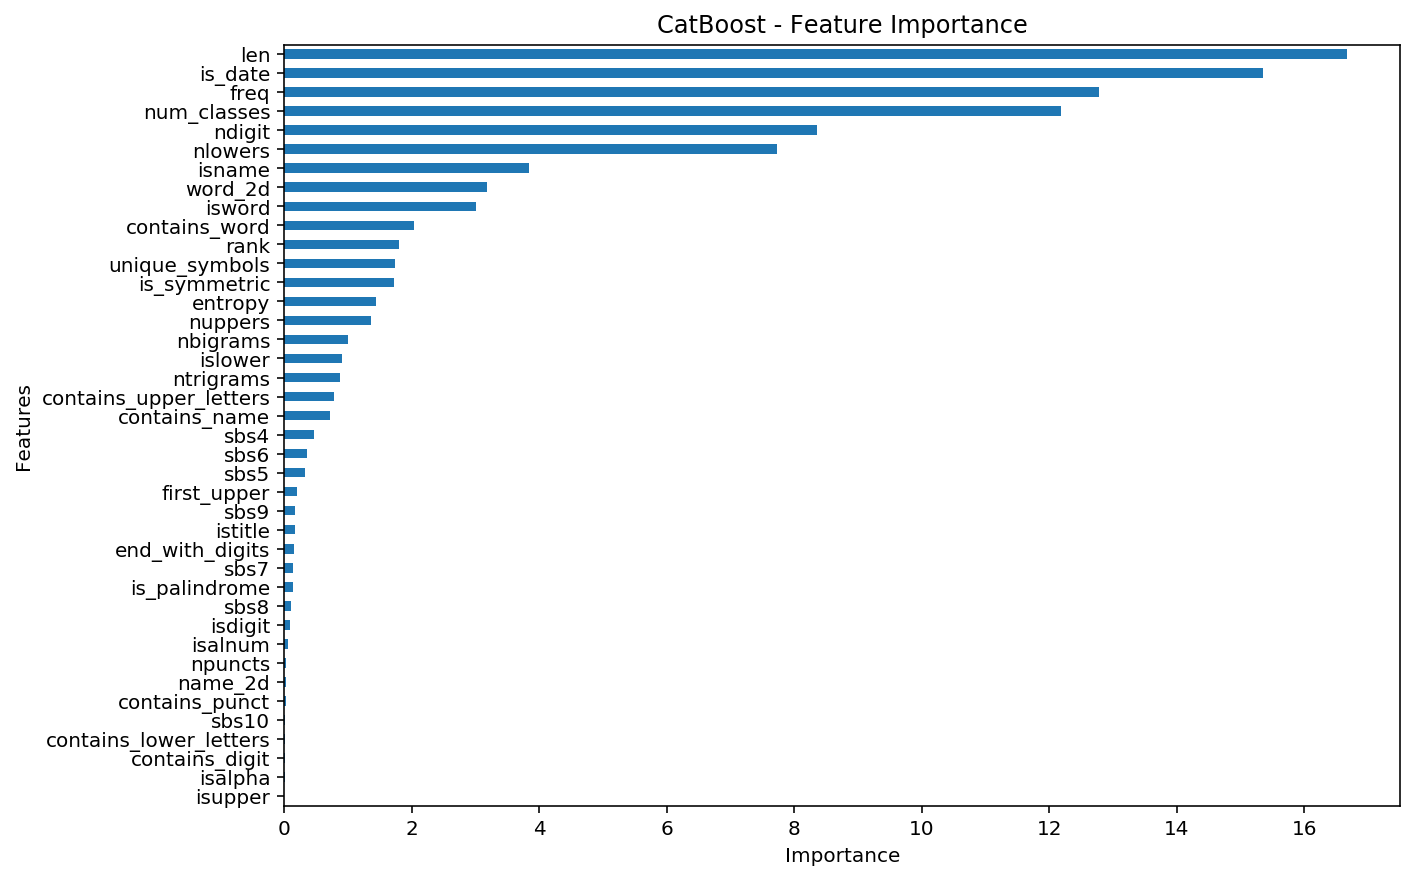

In [20]:
fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': X.drop(drop_feats, axis = 1).columns})

fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False])

fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance');

In [21]:
y_pred = model.predict(X_test)

In [22]:
y_pred.min(), y_pred.max()

(0.40604010763645704, 6.80750525924086)

In [23]:
y_test.min(), y_test.max()

(0.6931471805599453, 8.254788926148725)

In [24]:
# y_pred[y_pred < y_test.min()] = y_test.min()

In [25]:
y_pred_times = np.exp(y_pred) - 1

In [26]:
rmsle(y_pred_times, X.loc[y_test.index, 'Times'])

0.3505726689008937

In [27]:
model.fit(X.drop(drop_feats, axis = 1), y)

In [28]:
t = df[df['Times'] == 0].copy()

In [29]:
y_pred_submit = model.predict(t.drop(drop_feats, axis = 1))

In [30]:
y_pred_submit.min(), y_pred_submit.max()

(0.4447869069947501, 6.966227128730024)

In [31]:
y_pred_submit_times = np.exp(y_pred_submit) - 1

In [32]:
data = pd.DataFrame({'Id':t.index, 'Times':y_pred_submit_times})

In [33]:
data.head()

,Id,Times
0,4151495,1.050590
1,4151496,1.074280
2,4151497,1.041153
3,4151498,1.423371
4,4151499,1.344591


In [34]:
data['Id'] = data.index

In [35]:
data.to_csv('my_submission_regressor.csv', index = False)

## Эксперименты (сюда можно не смотреть)

In [19]:
from sklearn.manifold import TSNE

In [20]:
tsne = TSNE(n_components=2)

In [ ]:
X_train_emb = tsne.fit_transform(X_train)

In [301]:
X = df[df['Times'] > 0].copy()

In [302]:
y=X['class_log']

In [307]:
X_train, X_test, y_train, y_test = train_test_split(X.drop(drop_feats, axis = 1), y, test_size=0.20, random_state=42, stratify=X['class_log'])  #splitting

In [42]:
model = CatBoostClassifier(random_seed=42, logging_level='Silent', task_type="GPU", devices='0:1', depth=10, iterations=1250, loss_function='MultiClass')

In [43]:
model.fit(X_train, y_train, eval_set = (X_test, y_test), use_best_model=True)

In [44]:
y_pred = model.predict(X_test)

In [45]:
y_pred.min(), y_pred.max()

(0.0, 9.0)

In [48]:
y_pred = y_pred.astype('int')

In [49]:
y_test.min(), y_test.max()

(0, 9)

In [237]:
accuracy_score(y_pred, y_test)

0.8310175009243658

In [238]:
times_log_preds = means_log.loc[y_pred.flatten(), 'mean'].values

In [239]:
times_log_preds.min(), times_log_preds.max()

(0.6931471805918815, 4.612037792902566)

In [240]:
y_pred_times = np.exp(times_log_preds) - 1

In [241]:
rmsle(y_pred_times, X.loc[y_test.index, 'Times'])

0.6321072111870177

In [343]:
from sklearn.preprocessing import StandardScaler

In [344]:
scaler = StandardScaler()

In [345]:
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [346]:
X_train_norm = scaler.transform(X_train)

In [347]:
X_test_norm = scaler.transform(X_test)

In [353]:
X_train.groupby(X['class_log']).mean()

,len,freq,isword,isname,contains_name,isdigit,islower,contains_digit,contains_lower_letters,contains_upper_letters,entropy,unique_symbols,is_symmetric,end_with_digits,sbs4,sbs5,sbs6,num_classes,is_date,rank,contains_word
class_log,,,,,,,,,,,,,,,,,,,,,
0,8.496030,0.009317,0.006219,0.000595,0.332806,0.110246,0.705909,0.703244,0.851065,0.182202,2.671185,6.962243,0.005577,0.141584,0.012906,0.006319,0.003870,1.759015,0.010502,21.457547,0.218342
1,7.430002,0.042201,0.027179,0.003562,0.355116,0.178761,0.714308,0.634138,0.799090,0.106414,2.493970,6.127153,0.014105,0.180960,0.014683,0.006897,0.004071,1.545168,0.033954,19.235240,0.269768
2,7.169626,0.081072,0.051678,0.006855,0.378113,0.194130,0.723740,0.584476,0.786627,0.081729,2.438274,5.887819,0.023623,0.186653,0.015589,0.007503,0.004510,1.456175,0.056473,18.411005,0.294493
3,7.056730,0.108923,0.069072,0.009852,0.384587,0.214553,0.710924,0.558342,0.766371,0.074182,2.406475,5.770196,0.030448,0.181406,0.016115,0.008097,0.005450,1.401541,0.075099,17.956234,0.294814
4,6.938830,0.160306,0.098512,0.014265,0.380883,0.230389,0.696298,0.532801,0.750860,0.073125,2.375586,5.660407,0.034736,0.171287,0.016038,0.008355,0.005883,1.358747,0.107135,17.504188,0.307597
5,6.815568,0.223322,0.131484,0.017842,0.366667,0.283198,0.647206,0.533218,0.698651,0.069287,2.342290,5.539229,0.034836,0.147784,0.015954,0.008632,0.005934,1.302890,0.150790,17.020834,0.310443
6,6.785207,0.288514,0.160544,0.026057,0.331098,0.365496,0.574217,0.552097,0.620759,0.060121,2.319152,5.454743,0.028359,0.114470,0.015080,0.009308,0.006372,1.234711,0.200180,16.591958,0.295733
7,6.776656,0.338137,0.178786,0.030107,0.274757,0.459935,0.489764,0.597314,0.530153,0.050208,2.316921,5.423066,0.023807,0.082260,0.013803,0.009264,0.006299,1.178694,0.252895,16.382413,0.276610
8,7.025193,0.425121,0.216077,0.040661,0.273143,0.491446,0.482189,0.583783,0.501640,0.026248,2.322021,5.450199,0.024842,0.058238,0.013944,0.009374,0.006093,1.112491,0.138856,16.238314,0.284861


In [533]:
# df['len'].min(), df['len'].max()

# bins=[1,6,7,8,9,10,11,12,13,14,16,43]

# labels = list(range(len(bins) - 1))

# df.loc[df['Times'] > 0, 'len_class'] = pd.cut(x=df[df['Times'] > 0]['len'], bins=bins, labels = labels, right = False)

# df[df['Times'] > 0].groupby(['len_class']).size()

# df.head()

# df = pd.get_dummies(df, columns = ['len_class', 'num_classes'])

In [14]:
from sklearn.decomposition import PCA

In [15]:
len(X.drop(drop_feats, axis = 1).columns)

18

In [37]:
pca = PCA(n_components=1)

In [38]:
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=1, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [39]:
X_train_pca = pca.transform(X_train) 
X_test_pca = pca.transform(X_test)

In [40]:
from sklearn.metrics.pairwise import cosine_similarity

In [41]:
cs = cosine_similarity(X_test_pca, X_train_pca)

MemoryError: 

In [242]:
bins=[np.log1p(1),np.log1p(2),np.log1p(10),np.log1p(56000)]
labels = list(range(len(bins) - 1))
df.loc[df['Times'] > 0, 'class_log'] = pd.cut(x=df[df['Times'] > 0]['times_log'], bins=bins, labels = labels, right = False)

In [243]:
df[df['Times'] > 0].groupby(['class_log']).size()

class_log
0    3547155
1     532338
2      72002
dtype: int64

In [244]:
means_log = df[df['Times'] > 0].groupby(['class_log'])['times_log'].agg(['mean'])
means_log

,mean
class_log,
0,0.693147
1,1.328052
2,3.184348


In [245]:
times_log_preds = means_log.loc[df[df['Times'] > 0]['class_log'].values, 'mean'].values

In [246]:
times_preds = np.exp(times_log_preds) - 1

In [247]:
y_true = df[df['Times'] > 0]['Times']

In [248]:
rmsle(times_preds, y_true.values)

0.15383593299456597

In [308]:
y_test.unique()

array([0, 1, 2], dtype=int64)

In [309]:
y_pred = pd.Series(np.random.choice(y_test.unique(), size = len(y_test)), index = y_test.index)

In [310]:
y_pred[  X_test['num_classes'] >2     ] = 0

In [311]:
y_pred[  ~X_test['isname']     ] = 0

In [312]:
y_pred[  ~X_test['isword']     ] = 0

In [313]:
y_pred[  ~X_test['contains_name']     ] = 0

In [314]:
y_pred[  ~X_test['is_date']     ] = 0

In [315]:
y_pred[  X_test['len'] > 10     ] = 0

In [316]:
accuracy_score(y_pred, y_test)

0.8544307532587658

In [317]:
times_log_preds = means_log.loc[y_pred, 'mean'].values

In [318]:
times_log_preds.min(), times_log_preds.max()

(0.6931471805918815, 3.1843475841298994)

In [319]:
y_pred_times = np.exp(times_log_preds) - 1

In [320]:
rmsle(y_pred_times, X.loc[y_test.index, 'Times'])

0.4270183242663064

In [321]:
X_test.columns

Index(['len', 'freq', 'isword', 'isname', 'contains_name', 'isdigit',
       'islower', 'contains_digit', 'contains_lower_letters',
       'contains_upper_letters', 'entropy', 'unique_symbols', 'is_symmetric',
       'end_with_digits', 'sbs4', 'sbs5', 'sbs6', 'num_classes', 'is_date',
       'rank', 'contains_word'],
      dtype='object')

In [21]:
from sklearn.svm import SVR

In [22]:
clf = SVR(gamma='scale', C=1.0, epsilon=0.2)

In [ ]:
clf.fit(X_train_pca, y_train) 

In [395]:
from sklearn.preprocessing import MinMaxScaler
scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
X_train = scaling.transform(X_train)
X_test = scaling.transform(X_test)

In [232]:
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.naive_bayes import GaussianNB

In [233]:
clf = GaussianNB()

In [234]:
clf.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [235]:
y_pred = clf.predict(X_test)

In [236]:
y_pred.min(), y_pred.max()

(0, 9)

In [499]:
y_pred_times = np.exp(y_pred) - 1

In [500]:
rmsle(y_pred_times, X.loc[y_test.index, 'Times'])

0.40929085032564205

In [44]:
X_test

,len,freq,isword,isname,contains_name,isdigit,islower,isupper,contains_digit,contains_lower_letters,contains_upper_letters,entropy,unique_symbols,is_symmetric,end_with_digits,num_classes,is_date,rank
2274643,10,0.0,False,False,True,False,True,False,True,True,False,3.121928,9,False,True,2,False,24.743856
1866699,8,0.0,False,False,False,False,False,False,True,True,True,3.000000,8,False,False,3,False,28.000000
2154911,8,0.0,False,False,False,False,True,False,True,True,False,2.750000,7,False,False,2,False,23.000000
1547383,8,0.0,False,False,False,True,False,False,True,False,False,2.250000,5,False,False,1,False,16.000000
1923158,8,0.0,False,False,True,False,True,False,True,True,False,3.000000,8,False,True,2,False,23.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129416,9,0.0,False,False,False,False,True,False,True,True,False,1.752715,4,False,False,2,False,14.505431
3547837,8,0.0,False,False,False,False,True,False,True,True,False,3.000000,8,False,False,2,False,25.500000
1341430,6,0.0,False,False,False,False,False,True,True,False,True,1.918296,4,False,False,2,True,14.836592
2473892,6,0.0,False,False,False,False,True,False,False,True,False,2.251629,5,False,False,1,False,16.003258


In [45]:
X_test.describe()

,len,freq,entropy,unique_symbols,num_classes,rank
count,830299.000000,830299.000000,830299.000000,830299.000000,830299.000000,830299.000000
mean,8.308352,0.025377,2.637983,6.810300,1.715325,21.019430
std,2.430664,0.240321,0.447463,1.996563,0.653003,4.916144
min,3.000000,0.000000,0.000000,1.000000,0.000000,-8.500000
25%,7.000000,0.000000,2.321928,6.000000,1.000000,17.543281
50%,8.000000,0.000000,2.721928,7.000000,2.000000,20.849411
75%,9.000000,0.000000,2.947703,8.000000,2.000000,24.000000
max,40.000000,9.408915,4.700440,26.000000,4.000000,56.250000


In [46]:
X_train.describe()

,len,freq,entropy,unique_symbols,num_classes,rank
count,3.321196e+06,3.321196e+06,3.321196e+06,3.321196e+06,3.321196e+06,3.321196e+06
mean,8.309611e+00,2.495584e-02,2.637548e+00,6.809439e+00,1.713950e+00,2.101311e+01
std,2.434780e+00,2.367356e-01,4.479892e-01,1.998824e+00,6.530496e-01,4.918279e+00
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,-9.500000e+00
25%,7.000000e+00,0.000000e+00,2.321928e+00,6.000000e+00,1.000000e+00,1.754328e+01
50%,8.000000e+00,0.000000e+00,2.721928e+00,7.000000e+00,2.000000e+00,2.084386e+01
75%,9.000000e+00,0.000000e+00,2.947703e+00,8.000000e+00,2.000000e+00,2.400000e+01
max,4.200000e+01,1.148828e+01,5.155399e+00,3.600000e+01,4.000000e+00,7.131080e+01


In [48]:
df.select_dtypes(include='bool').columns

Index(['isword', 'isname', 'contains_name', 'isdigit', 'isalpha', 'islower',
       'isupper', 'istitle', 'isalnum', 'contains_punct', 'contains_digit',
       'contains_lower_letters', 'contains_upper_letters', 'is_palindrome',
       'is_symmetric', 'end_with_digits', 'sbs4', 'sbs5', 'sbs6', 'sbs7',
       'sbs8', 'sbs9', 'sbs10', 'is_date'],
      dtype='object')